In [2]:
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import mannwhitneyu

In [3]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "monge": default_colors["cyan"],
    "cmonge": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [4]:
sns.set(font="Arial")
sns.set_context("paper")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [5]:
base_fig_dir = "/path/to/figures/cmonge/"

In [6]:
exp_order = ["cmonge", "identity"] + ["within condition"]*32

all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    for embedding in ["11d", "16d", "metadata", "esm_small_tail_dim", "esm_XL_tail_dim", "esm_large_tail_dim"]:
        with open(f"/path/to/model/logs/{subset}_{embedding}_FuncScore/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        if len(logs["experiments"])==68:
            print("using only the first 34 logs")
            logs["experiments"]=logs["experiments"][:34]
        print(subset, embedding, len(logs["experiments"]))
        
        for i in range(len(logs["experiments"])):
            eval_setting = exp_order[i]
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["embedding"] = embedding
                res["eval_car"] = condition
                res["eval_setting"] = eval_setting
                res["subset"] = subset
                all_mean_metrics.append(res)

CD4 11d 34
CD4 16d 34
CD4 metadata 34
CD4 esm_small_tail_dim 34
CD4 esm_XL_tail_dim 34
CD4 esm_large_tail_dim 34
CD8 11d 34
CD8 16d 34
CD8 metadata 34
CD8 esm_small_tail_dim 34
CD8 esm_XL_tail_dim 34
CD8 esm_large_tail_dim 34


In [7]:
res = pd.concat(all_mean_metrics).reset_index(drop=True)
res = res[~res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
res.loc[res["embedding"]=="esm_large_tail_dim", "embedding"] = "ESM large"
res.loc[res["embedding"]=="esm_XL_tail_dim", "embedding"] = "ESM XL"
res.loc[res["embedding"]=="esm_small_tail_dim", "embedding"] = "ESM small"
res

,metric,score,embedding,eval_car,eval_setting,subset
0,mean_wasserstein,5.571434,11d,41BB-41BB-z,cmonge,CD4
1,mean_mmd,0.025381,11d,41BB-41BB-z,cmonge,CD4
2,mean_sinkhorn div,5.096906,11d,41BB-41BB-z,cmonge,CD4
3,mean_monge_gap,11.406399,11d,41BB-41BB-z,cmonge,CD4
4,mean_drug_signature,0.749129,11d,41BB-41BB-z,cmonge,CD4
...,...,...,...,...,...,...
6895,mean_mmd,0.012517,ESM large,IL15RA-NA-z,within condition,CD8
6896,mean_sinkhorn div,5.679140,ESM large,IL15RA-NA-z,within condition,CD8
6897,mean_monge_gap,12.339099,ESM large,IL15RA-NA-z,within condition,CD8
6898,mean_drug_signature,0.805206,ESM large,IL15RA-NA-z,within condition,CD8


# Compare embeddings

In [8]:
default_colors

{'indigo': '#332288',
 'cyan': '#88CCEE',
 'teal': '#44AA99',
 'green': '#117733',
 'olive': '#999933',
 'sand': '#DDCC77',
 'rose': '#CC6677',
 'wine': '#882255',
 'purple': '#AA4499',
 'grey': '#DDDDDD'}

In [9]:
embedding_map = {"11d": default_colors["teal"],
                "16d": default_colors["cyan"],
                "metadata": default_colors["purple"],
                "ESM small": default_colors["sand"],
                # "ESM large": default_colors["olive"],
                "ESM XL": default_colors["green"]}

In [10]:
res = res[res["embedding"]!="ESM large"]

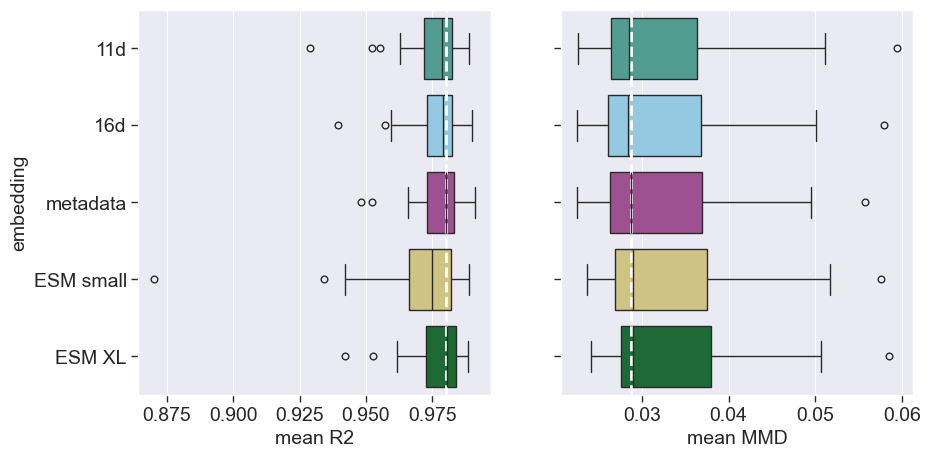

In [11]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(10, 5))

plt_data = res[(res["eval_setting"]=="cmonge")&(res["metric"]=="mean_r2")&(res["subset"]=="CD8")]
sns.boxplot(data=plt_data, x="score", y="embedding", hue="embedding", ax=axes[0],
           palette=embedding_map, order=embedding_map.keys())
axes[0].set_ylabel("embedding", fontsize=14)
axes[0].set_xlabel("mean R2", fontsize=14)
axes[0].tick_params(which="both", axis="both", labelsize=14)
axes[0].axvline(x=plt_data.loc[plt_data["embedding"]=="metadata", 'score'].median(),
               linestyle="--", color="white", linewidth=2)

plt_data = res[(res["eval_setting"]=="cmonge")&(res["metric"]=="mean_mmd")]
sns.boxplot(data=plt_data, x="score", y="embedding",  hue="embedding", ax=axes[1],
           palette=embedding_map, order=embedding_map.keys())
axes[1].set_ylabel("embedding", fontsize=14)
axes[1].set_xlabel("mean MMD", fontsize=14)
axes[1].tick_params(which="both", axis="both", labelsize=14)
axes[1].axvline(x=plt_data.loc[plt_data["embedding"]=="metadata", 'score'].median(),
                linestyle="--", color="white", linewidth=2)
plt.savefig(f"{base_fig_dir}embedding_comparison.pdf", bbox_inches="tight")

In [12]:
sel_res = res[res["embedding"]=="ESM XL"]

In [16]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("cmonge", "identity"), ("cmonge", "within condition")]:
            stats_res = sel_res[(sel_res["metric"]==metric)&(sel_res["subset"]==subset)]

            pval = mannwhitneyu(stats_res.loc[stats_res["eval_setting"]==comparison[0], "score"], 
                                stats_res.loc[stats_res["eval_setting"]==comparison[1], 'score'],
                                ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,4.182500e-09,CD8,mean_mmd,cmonge,identity,3.346000e-08,0.00625,True,True
1,8.663433e-05,CD8,mean_mmd,cmonge,within condition,6.930746e-04,0.00625,True,True
2,1.286039e-06,CD4,mean_mmd,cmonge,identity,1.028831e-05,0.00625,True,True
3,2.597360e-05,CD4,mean_mmd,cmonge,within condition,2.077888e-04,0.00625,True,True
4,3.019859e-11,CD8,mean_r2,cmonge,identity,2.415887e-10,0.00625,True,True
5,6.100076e-01,CD8,mean_r2,cmonge,within condition,4.880060e+00,0.00625,False,False
6,3.019859e-11,CD4,mean_r2,cmonge,identity,2.415887e-10,0.00625,True,True
7,1.579757e-01,CD4,mean_r2,cmonge,within condition,1.263806e+00,0.00625,False,False


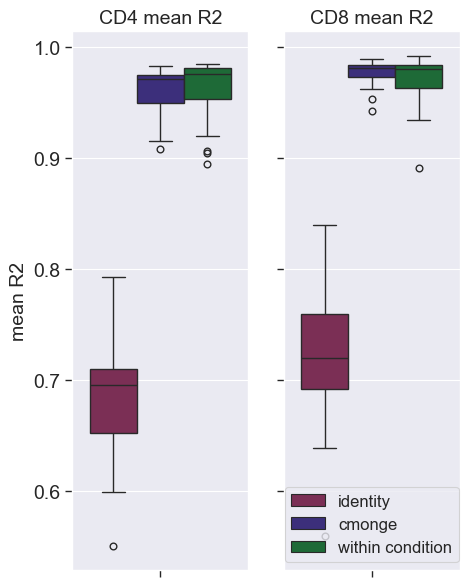

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}R2_performance.pdf", bbox_inches="tight")

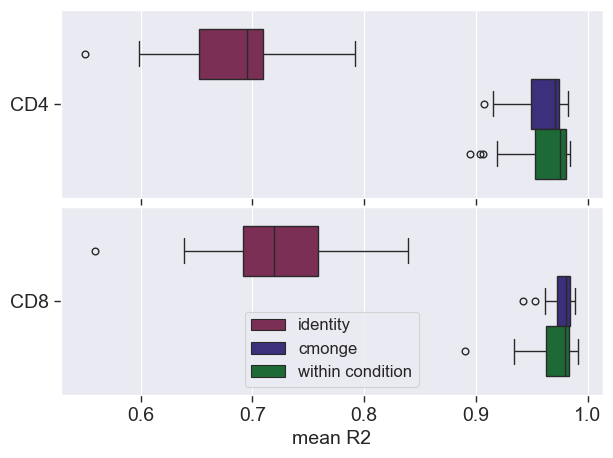

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}R2_performance_horizontal.pdf", bbox_inches="tight")

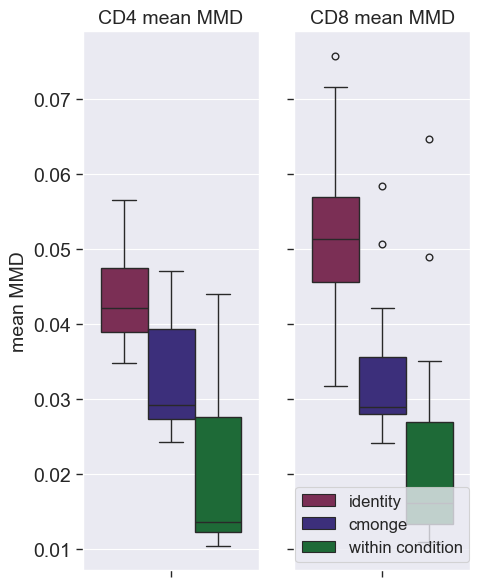

In [14]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}MMD_performance.pdf", bbox_inches="tight")

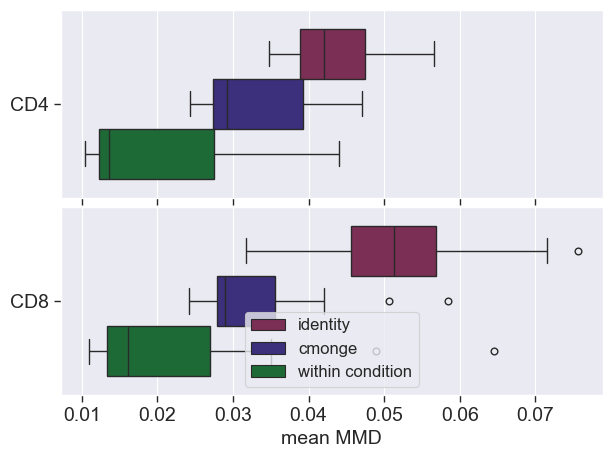

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}MMD_performance_horizontal.pdf", bbox_inches="tight")

# Scores per CAR

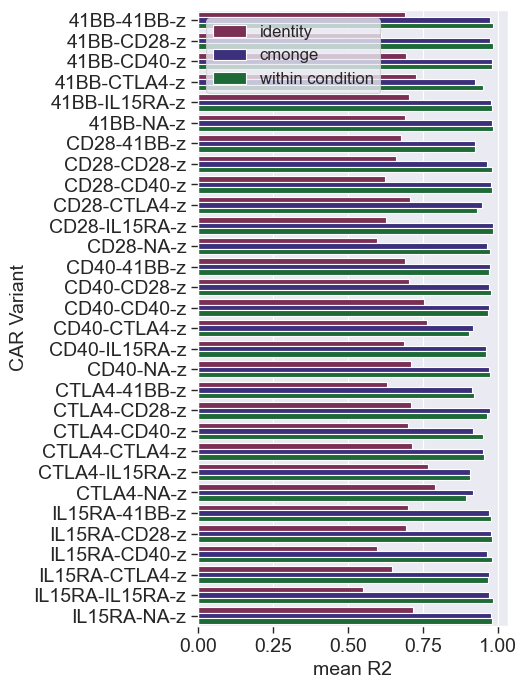

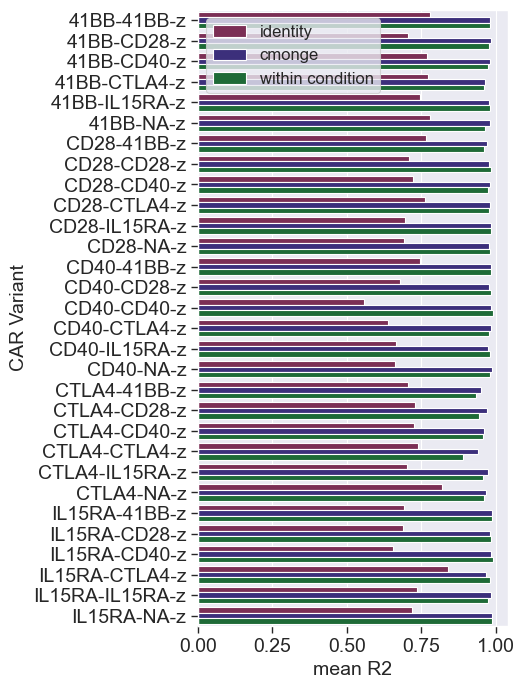

In [16]:
for subset in ["CD4", "CD8"]:
    plt_data = sel_res[(sel_res["metric"]=="mean_r2")&(sel_res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "cmonge", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean R2", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}R2_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

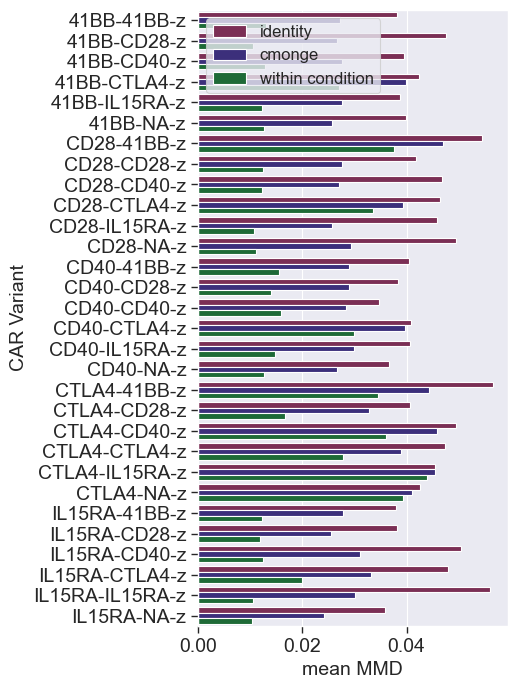

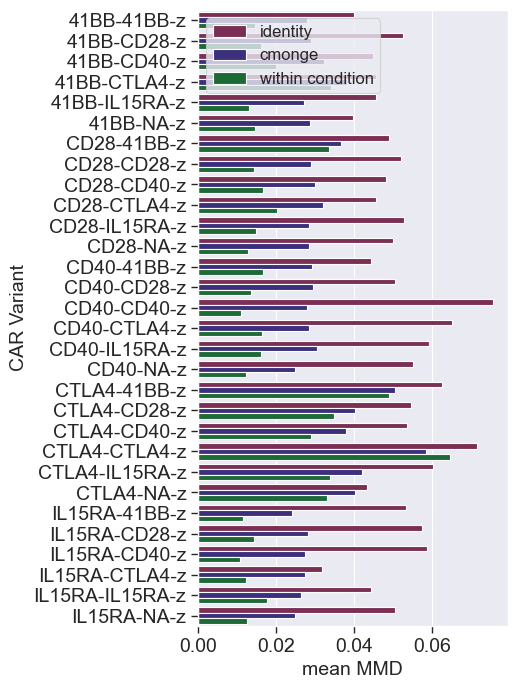

In [17]:
for subset in ["CD4", "CD8"]:
    plt_data = sel_res[(sel_res["metric"]=="mean_mmd")&(sel_res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "cmonge", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean MMD", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}MMD_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

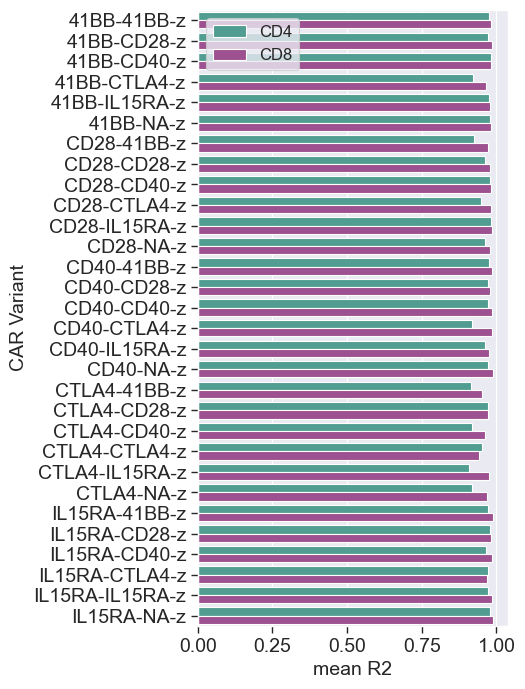

In [18]:
plt_data = sel_res[(sel_res["metric"]=="mean_r2")&(sel_res["eval_setting"]=="cmonge")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="score", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}R2_per_car.pdf", bbox_inches="tight")
plt.show()

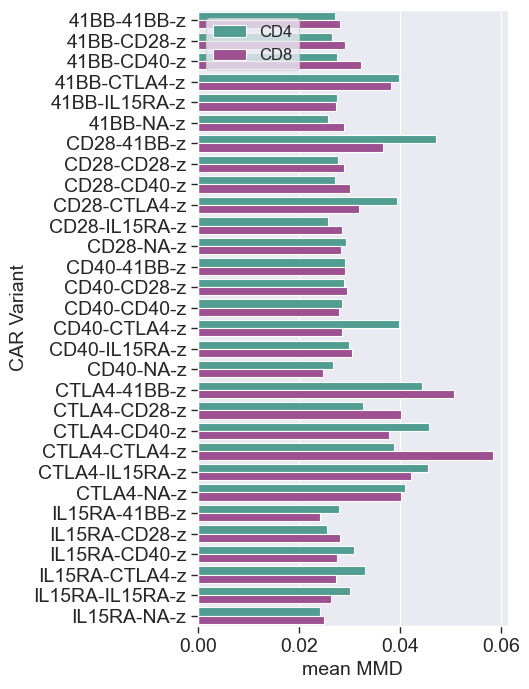

In [19]:
plt_data = sel_res[(sel_res["metric"]=="mean_mmd")&(sel_res["eval_setting"]=="cmonge")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="score", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}MMD_per_car.pdf", bbox_inches="tight")
plt.show()

# Using only selected CARs with best embedding

In [17]:
exp_order = ["cmonge", "identity"] + ["within condition"]*32

all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    for embedding in ["esm_large_tail_dim"]:
        with open(f"/path/to/model/logs/sel/cars/{subset}_{embedding}_FuncScore/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        if len(logs["experiments"])==68:
            print("using only the first 34 logs")
            logs["experiments"]=logs["experiments"][:34]
        print(subset, embedding, len(logs["experiments"]))
        
        for i in range(len(logs["experiments"])):
            eval_setting = exp_order[i]
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["embedding"] = embedding
                res["eval_car"] = condition
                res["eval_setting"] = eval_setting
                res["subset"] = subset
                all_mean_metrics.append(res)

CD4 esm_large_tail_dim 18
CD8 esm_large_tail_dim 16


In [18]:
res = pd.concat(all_mean_metrics).reset_index(drop=True)
res = res[~res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
res.loc[res["embedding"]=="esm_XL_tail_dim", "embedding"] = "ESM XL"
res

,metric,score,embedding,eval_car,eval_setting,subset
0,mean_wasserstein,5.480080,esm_large_tail_dim,CD28-IL15RA-z,cmonge,CD4
1,mean_mmd,0.024648,esm_large_tail_dim,CD28-IL15RA-z,cmonge,CD4
2,mean_sinkhorn div,4.993947,esm_large_tail_dim,CD28-IL15RA-z,cmonge,CD4
3,mean_monge_gap,11.410242,esm_large_tail_dim,CD28-IL15RA-z,cmonge,CD4
4,mean_drug_signature,0.681958,esm_large_tail_dim,CD28-IL15RA-z,cmonge,CD4
...,...,...,...,...,...,...
535,mean_mmd,0.014717,esm_large_tail_dim,41BB-41BB-z,within condition,CD8
536,mean_sinkhorn div,5.485166,esm_large_tail_dim,41BB-41BB-z,within condition,CD8
537,mean_monge_gap,12.362149,esm_large_tail_dim,41BB-41BB-z,within condition,CD8
538,mean_drug_signature,0.886871,esm_large_tail_dim,41BB-41BB-z,within condition,CD8


In [19]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("cmonge", "identity"), ("cmonge", "within condition")]:
            stats_res = res[(res["metric"]==metric)&(res["subset"]==subset)]

            pval = mannwhitneyu(stats_res.loc[stats_res["eval_setting"]==comparison[0], "score"], 
                                stats_res.loc[stats_res["eval_setting"]==comparison[1], 'score'],
                                ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,0.000007,CD8,mean_mmd,cmonge,identity,0.000060,0.00625,True,True
1,0.000007,CD8,mean_mmd,cmonge,within condition,0.000060,0.00625,True,True
2,0.000002,CD4,mean_mmd,cmonge,identity,0.000012,0.00625,True,True
3,0.000002,CD4,mean_mmd,cmonge,within condition,0.000012,0.00625,True,True
4,0.000007,CD8,mean_r2,cmonge,identity,0.000060,0.00625,True,True
5,0.421348,CD8,mean_r2,cmonge,within condition,3.370786,0.00625,False,False
6,0.000002,CD4,mean_r2,cmonge,identity,0.000012,0.00625,True,True
7,0.027468,CD4,mean_r2,cmonge,within condition,0.219744,0.00625,False,False


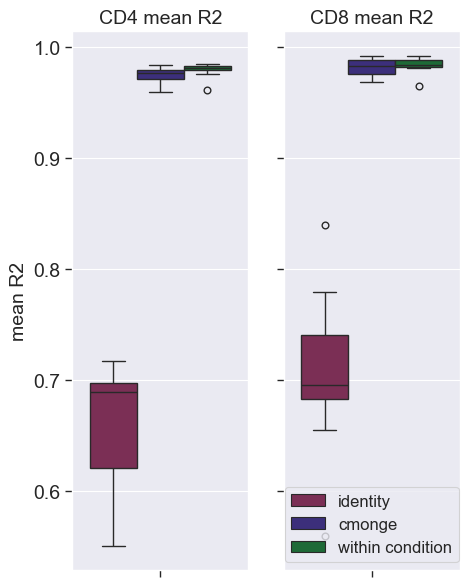

In [23]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_performance.pdf", bbox_inches="tight")

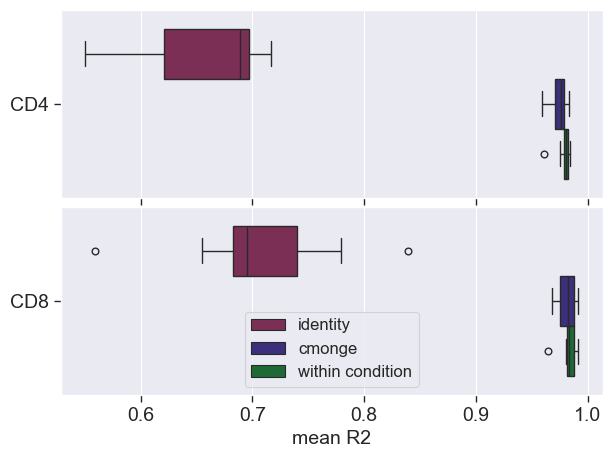

In [24]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_performance_horizontal.pdf", bbox_inches="tight")

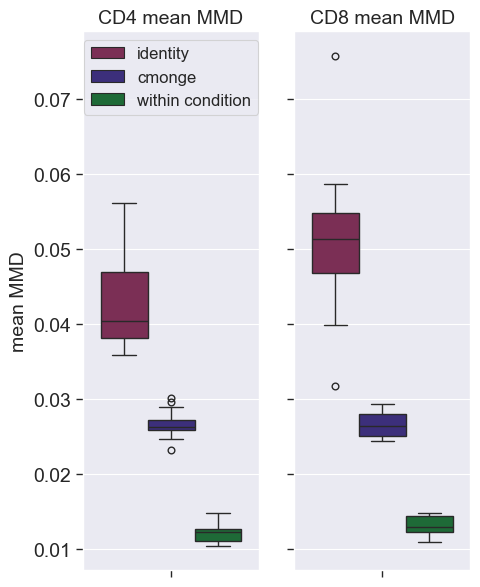

In [25]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}sel_CARs_MMD_performance.pdf", bbox_inches="tight")

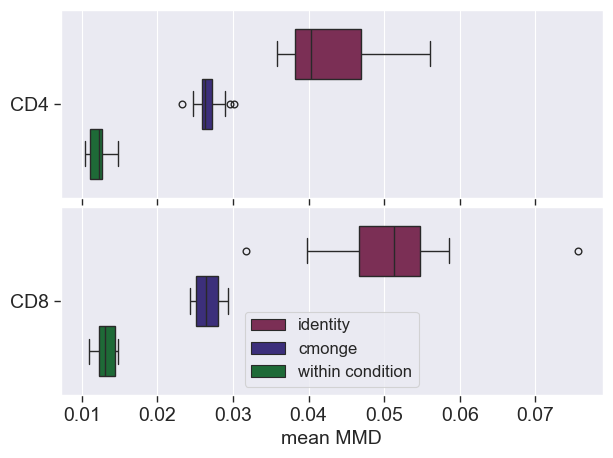

In [26]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}sel_CARs_MMD_performance_horizontal.pdf", bbox_inches="tight")

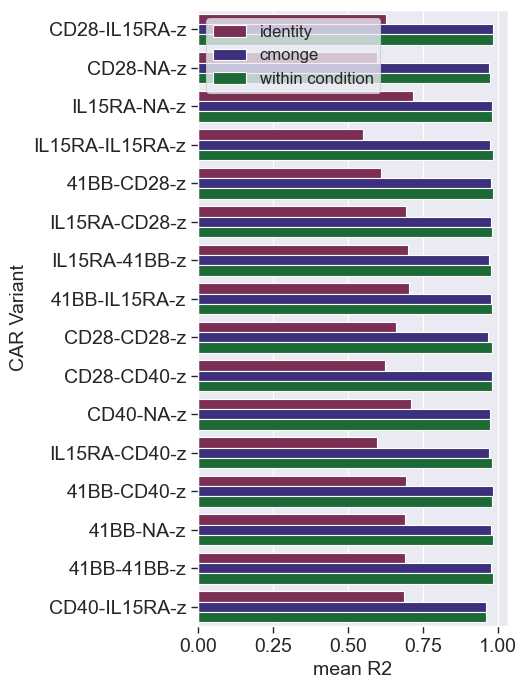

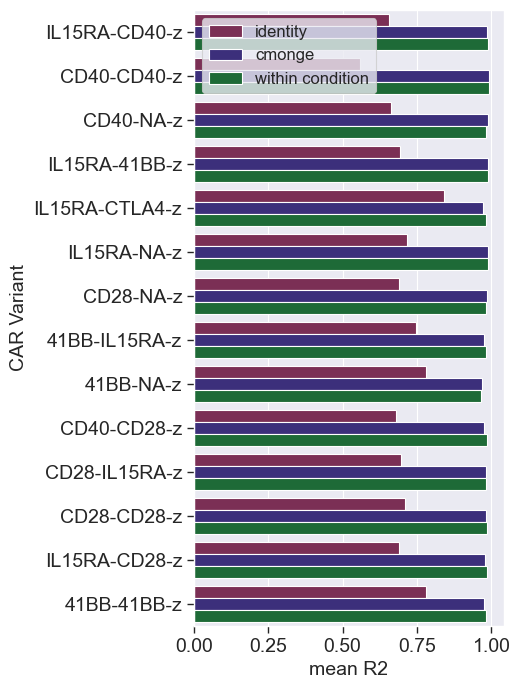

In [27]:
for subset in ["CD4", "CD8"]:
    plt_data = res[(res["metric"]=="mean_r2")&(res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "cmonge", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean R2", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}sel_CARs_R2_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

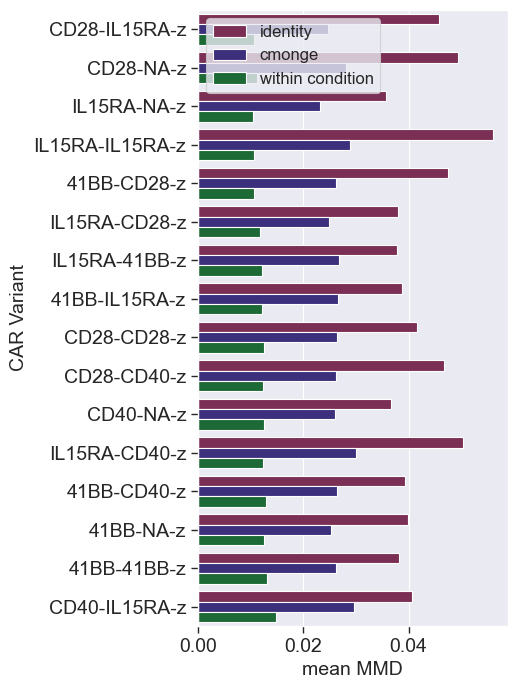

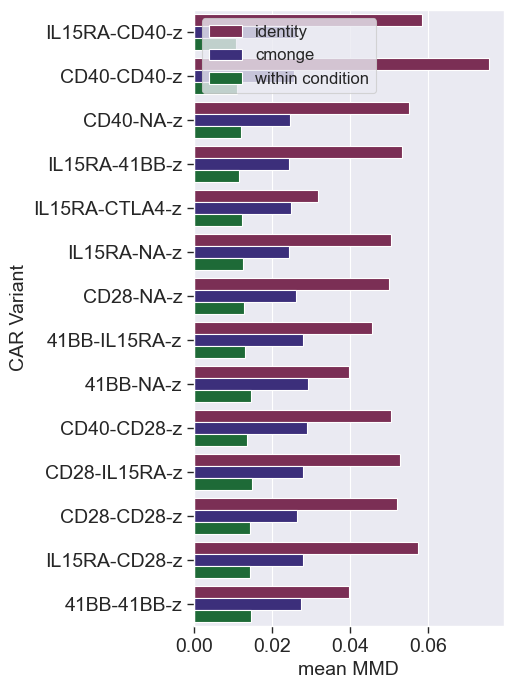

In [28]:
for subset in ["CD4", "CD8"]:
    plt_data = res[(res["metric"]=="mean_mmd")&(res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "cmonge", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean MMD", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}sel_CARs_MMD_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

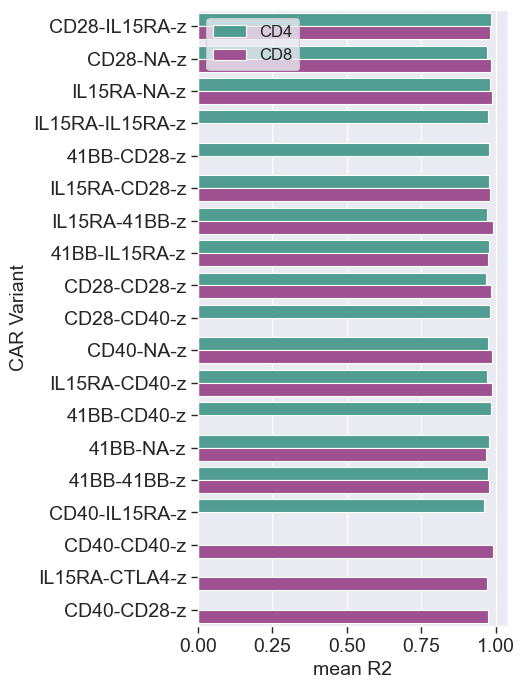

In [29]:
plt_data = res[(res["metric"]=="mean_r2")&(res["eval_setting"]=="cmonge")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="score", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_per_car.pdf", bbox_inches="tight")
plt.show()

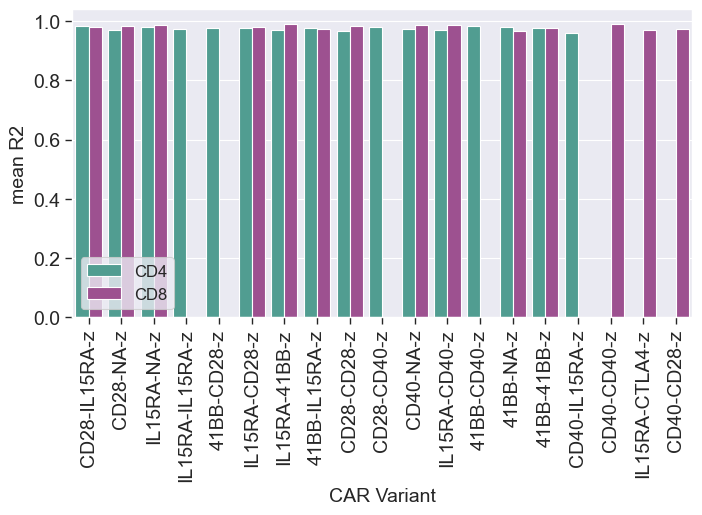

In [32]:
plt_data = res[(res["metric"]=="mean_r2")&(res["eval_setting"]=="cmonge")]
plt.figure(figsize=(8,4))
sns.barplot(data=plt_data, y="score", x="eval_car", hue="subset", palette=subset_map)
plt.xlabel("CAR Variant", fontsize=14)
plt.ylabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="lower left", title="", fontsize=12)
plt.xticks(rotation=90)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_per_car_horizontal.pdf", bbox_inches="tight")
plt.show()

In [34]:
plt_data['score'].min()

0.9591805297072376

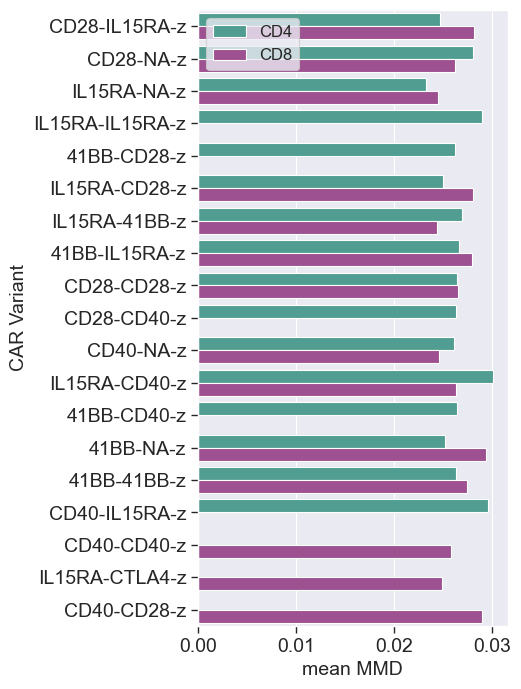

In [31]:
plt_data = res[(res["metric"]=="mean_mmd")&(res["eval_setting"]=="cmonge")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="score", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}sel_CARs_MMD_per_car.pdf", bbox_inches="tight")
plt.show()